 # Power Load Prediction for West Zone - Random Forest Model
 
 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [3]:
power_data_west = pd.read_csv("westdata_augmented.csv")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
power_data_west.head(10)

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,sfm,index_y,dt,dt_iso,humidity,humidity_temp,pt_date
0,0,0,west,2019-01-29 00:00:00,2019-01-29 00:15:00,211.2,NaN,54.0,NaN,844.8,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
1,1,1,west,2019-01-29 00:15:00,2019-01-29 00:30:00,210.4,NaN,54.0,NaN,841.6,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
2,2,2,west,2019-01-29 00:30:00,2019-01-29 00:45:00,208.0,NaN,54.0,NaN,832.0,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
3,3,3,west,2019-01-29 00:45:00,2019-01-29 01:00:00,212.0,NaN,54.0,NaN,848.0,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
4,4,4,west,2019-01-29 01:00:00,2019-01-29 01:15:00,203.2,NaN,55.0,NaN,812.8,2019-01-29 01,681,1548752400,2019-01-29 09,21,63.41,2019-01-29 01
5,5,5,west,2019-01-29 01:15:00,2019-01-29 01:30:00,205.6,NaN,55.0,NaN,822.4,2019-01-29 01,681,1548752400,2019-01-29 09,21,63.41,2019-01-29 01
6,6,6,west,2019-01-29 01:30:00,2019-01-29 01:45:00,205.6,NaN,55.0,NaN,822.4,2019-01-29 01,681,1548752400,2019-01-29 09,21,63.41,2019-01-29 01
7,7,7,west,2019-01-29 01:45:00,2019-01-29 02:00:00,208.8,NaN,55.0,NaN,835.2,2019-01-29 01,681,1548752400,2019-01-29 09,21,63.41,2019-01-29 01
8,8,8,west,2019-01-29 02:00:00,2019-01-29 02:15:00,217.6,NaN,55.0,NaN,870.4,2019-01-29 02,682,1548756000,2019-01-29 10,22,62.98,2019-01-29 02
9,9,9,west,2019-01-29 02:15:00,2019-01-29 02:30:00,229.6,NaN,55.0,NaN,918.4,2019-01-29 02,682,1548756000,2019-01-29 10,22,62.98,2019-01-29 02


In [5]:
power_data_west['end'] = pd.to_datetime(power_data_west['end'], infer_datetime_format=True)
indexedDataset = power_data_west.set_index(['end'])

In [6]:
plot_df_west = pd.DataFrame(power_data_west, columns=['demand', 'temp', 'end', 'humidity'])

In [7]:
plot_df_west['end'].min()

Timestamp('2019-01-29 00:15:00')

In [8]:
plot_df_west['end'].max()

Timestamp('2022-01-25 16:00:00')

In [10]:
power_data_west['month'] = power_data_west['end'].dt.strftime('%b')

In [11]:
from calendar import month_abbr

lower_ma = [m.lower() for m in month_abbr]

# one-liner with Pandas
power_data_west['month_int'] = power_data_west['month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')

In [12]:
power_data_west['day_of_week'] = power_data_west['end'].dt.day_name()

In [14]:
power_data_west['day_of_week_int'] = power_data_west['end'].dt.strftime("%w")

In [16]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

date_range = pd.date_range(start='2019-01-01', end='2022-01-27')

cal = calendar()
holidays = cal.holidays(start=date_range.min(), end=date_range.max())

power_data_west['holiday'] = power_data_west['end'].dt.date.astype('datetime64').isin(holidays)

In [17]:
power_data_west["holiday_int"] = power_data_west["holiday"].astype(int)

In [18]:
power_data_west.head(10)

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,...,dt_iso,humidity,humidity_temp,pt_date,month,month_int,day_of_week,day_of_week_int,holiday,holiday_int
0,0,0,west,2019-01-29 00:00:00,2019-01-29 00:15:00,211.2,NaN,54.0,NaN,844.8,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
1,1,1,west,2019-01-29 00:15:00,2019-01-29 00:30:00,210.4,NaN,54.0,NaN,841.6,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
2,2,2,west,2019-01-29 00:30:00,2019-01-29 00:45:00,208.0,NaN,54.0,NaN,832.0,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
3,3,3,west,2019-01-29 00:45:00,2019-01-29 01:00:00,212.0,NaN,54.0,NaN,848.0,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
4,4,4,west,2019-01-29 01:00:00,2019-01-29 01:15:00,203.2,NaN,55.0,NaN,812.8,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
5,5,5,west,2019-01-29 01:15:00,2019-01-29 01:30:00,205.6,NaN,55.0,NaN,822.4,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
6,6,6,west,2019-01-29 01:30:00,2019-01-29 01:45:00,205.6,NaN,55.0,NaN,822.4,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
7,7,7,west,2019-01-29 01:45:00,2019-01-29 02:00:00,208.8,NaN,55.0,NaN,835.2,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
8,8,8,west,2019-01-29 02:00:00,2019-01-29 02:15:00,217.6,NaN,55.0,NaN,870.4,...,2019-01-29 10,22,62.98,2019-01-29 02,Jan,1,Tuesday,2,False,0
9,9,9,west,2019-01-29 02:15:00,2019-01-29 02:30:00,229.6,NaN,55.0,NaN,918.4,...,2019-01-29 10,22,62.98,2019-01-29 02,Jan,1,Tuesday,2,False,0


In [19]:
power_data_west.tail(10)

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,...,dt_iso,humidity,humidity_temp,pt_date,month,month_int,day_of_week,day_of_week_int,holiday,holiday_int
104598,104598,104598,west,2022-01-25 13:30:00,2022-01-25 13:45:00,301.6,NaN,66.0,NaN,1206.4,...,2022-01-25 21,37,68.23,2022-01-25 13,Jan,1,Tuesday,2,False,0
104599,104599,104599,west,2022-01-25 13:45:00,2022-01-25 14:00:00,300.0,NaN,66.0,NaN,1200.0,...,2022-01-25 21,37,68.23,2022-01-25 13,Jan,1,Tuesday,2,False,0
104600,104600,104600,west,2022-01-25 14:00:00,2022-01-25 14:15:00,300.8,NaN,67.0,NaN,1203.2,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104601,104601,104601,west,2022-01-25 14:15:00,2022-01-25 14:30:00,309.6,NaN,67.0,NaN,1238.4,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104602,104602,104602,west,2022-01-25 14:30:00,2022-01-25 14:45:00,297.6,NaN,67.0,NaN,1190.4,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104603,104603,104603,west,2022-01-25 14:45:00,2022-01-25 15:00:00,297.6,NaN,67.0,NaN,1190.4,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104604,104604,104604,west,2022-01-25 15:00:00,2022-01-25 15:15:00,295.2,NaN,67.0,NaN,1180.8,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0
104605,104605,104605,west,2022-01-25 15:15:00,2022-01-25 15:30:00,304.8,NaN,67.0,NaN,1219.2,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0
104606,104606,104606,west,2022-01-25 15:30:00,2022-01-25 15:45:00,309.6,NaN,67.0,NaN,1238.4,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0
104607,104607,104607,west,2022-01-25 15:45:00,2022-01-25 16:00:00,296.8,NaN,67.0,NaN,1187.2,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0


In [20]:
power_data_west.describe()

,Unnamed: 0,index_x,usage,cost,temp,demand,index_y,dt,humidity,humidity_temp,month_int,holiday_int
count,104608.000000,104608.000000,104596.000000,0.0,104588.00000,104596.000000,104608.000000,1.046080e+05,104608.000000,104608.000000,104608.00000,104608.000000
mean,52303.500000,52303.500000,309.658615,NaN,67.39232,1238.634456,13764.530284,1.595853e+09,52.635401,68.527903,6.54298,0.027531
std,30197.872817,30197.872817,75.599852,NaN,16.59371,302.399419,7560.847033,2.721905e+07,22.815913,15.741494,3.43464,0.163627
min,0.000000,0.000000,0.000000,NaN,29.00000,0.000000,680.000000,1.548749e+09,3.000000,32.200000,1.00000,0.000000
25%,26151.750000,26151.750000,252.000000,NaN,54.00000,1008.000000,7217.750000,1.572285e+09,34.000000,55.850000,4.00000,0.000000
50%,52303.500000,52303.500000,308.000000,NaN,66.00000,1232.000000,13755.500000,1.595821e+09,49.000000,66.900000,7.00000,0.000000
75%,78455.250000,78455.250000,368.000000,NaN,79.00000,1472.000000,20317.250000,1.619443e+09,70.000000,80.550000,10.00000,0.000000
max,104607.000000,104607.000000,531.200000,NaN,114.00000,2124.800000,26903.000000,1.643152e+09,100.000000,110.680000,12.00000,1.000000


In [13]:
power_data_west.shape

(104736, 15)

In [14]:
power_data_west.dtypes

Service Agreement            object
Start Date Time              object
End Date Time        datetime64[ns]
Usage                       float64
Usage Unit                   object
Cost                        float64
Currency Unit               float64
Avg. Temperature            float64
Temperature Unit             object
Event Flags                  object
Peak Demand                 float64
Demand Unit                  object
month                        object
day_of_week                  object
holiday                        bool
dtype: object

In [21]:
#For checking missing values in dataset
power_data_west.isna().sum()

Unnamed: 0              0
index_x                 0
service                 0
start                   0
end                     0
usage                  12
cost               104608
temp                   20
event_flag         104602
demand                 12
sfm                     0
index_y                 0
dt                      0
dt_iso                  0
humidity                0
humidity_temp           0
pt_date                 0
month                   0
month_int               0
day_of_week             0
day_of_week_int         0
holiday                 0
holiday_int             0
dtype: int64

In [22]:
power_data_west.fillna(method='ffill',inplace=True)
power_data_west.isna().sum()

Unnamed: 0              0
index_x                 0
service                 0
start                   0
end                     0
usage                   0
cost               104608
temp                    0
event_flag           3840
demand                  0
sfm                     0
index_y                 0
dt                      0
dt_iso                  0
humidity                0
humidity_temp           0
pt_date                 0
month                   0
month_int               0
day_of_week             0
day_of_week_int         0
holiday                 0
holiday_int             0
dtype: int64

In [23]:
zero_usage_df = power_data_west.loc[power_data_west['demand'] == 0]
zero_usage_df.count()

Unnamed: 0         50
index_x            50
service            50
start              50
end                50
usage              50
cost                0
temp               50
event_flag         50
demand             50
sfm                50
index_y            50
dt                 50
dt_iso             50
humidity           50
humidity_temp      50
pt_date            50
month              50
month_int          50
day_of_week        50
day_of_week_int    50
holiday            50
holiday_int        50
dtype: int64

In [24]:
power_data_west = power_data_west[power_data_west['demand'] != 0]
zero_usage_df = power_data_west.loc[power_data_west['demand'] == 0]
zero_usage_df.count()

Unnamed: 0         0
index_x            0
service            0
start              0
end                0
usage              0
cost               0
temp               0
event_flag         0
demand             0
sfm                0
index_y            0
dt                 0
dt_iso             0
humidity           0
humidity_temp      0
pt_date            0
month              0
month_int          0
day_of_week        0
day_of_week_int    0
holiday            0
holiday_int        0
dtype: int64

dataset.kW.plot()

## Random Forest Model

In [25]:
random_forest_data = power_data_west[(power_data_west['end'] > '2019-01-01') & (power_data_west['end'] < '2022-02-01')]

In [26]:
random_forest_data.head(10)

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,...,dt_iso,humidity,humidity_temp,pt_date,month,month_int,day_of_week,day_of_week_int,holiday,holiday_int
0,0,0,west,2019-01-29 00:00:00,2019-01-29 00:15:00,211.2,NaN,54.0,NaN,844.8,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
1,1,1,west,2019-01-29 00:15:00,2019-01-29 00:30:00,210.4,NaN,54.0,NaN,841.6,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
2,2,2,west,2019-01-29 00:30:00,2019-01-29 00:45:00,208.0,NaN,54.0,NaN,832.0,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
3,3,3,west,2019-01-29 00:45:00,2019-01-29 01:00:00,212.0,NaN,54.0,NaN,848.0,...,2019-01-29 08,21,63.86,2019-01-29 00,Jan,1,Tuesday,2,False,0
4,4,4,west,2019-01-29 01:00:00,2019-01-29 01:15:00,203.2,NaN,55.0,NaN,812.8,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
5,5,5,west,2019-01-29 01:15:00,2019-01-29 01:30:00,205.6,NaN,55.0,NaN,822.4,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
6,6,6,west,2019-01-29 01:30:00,2019-01-29 01:45:00,205.6,NaN,55.0,NaN,822.4,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
7,7,7,west,2019-01-29 01:45:00,2019-01-29 02:00:00,208.8,NaN,55.0,NaN,835.2,...,2019-01-29 09,21,63.41,2019-01-29 01,Jan,1,Tuesday,2,False,0
8,8,8,west,2019-01-29 02:00:00,2019-01-29 02:15:00,217.6,NaN,55.0,NaN,870.4,...,2019-01-29 10,22,62.98,2019-01-29 02,Jan,1,Tuesday,2,False,0
9,9,9,west,2019-01-29 02:15:00,2019-01-29 02:30:00,229.6,NaN,55.0,NaN,918.4,...,2019-01-29 10,22,62.98,2019-01-29 02,Jan,1,Tuesday,2,False,0


In [27]:
random_forest_data.tail(10)

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,...,dt_iso,humidity,humidity_temp,pt_date,month,month_int,day_of_week,day_of_week_int,holiday,holiday_int
104598,104598,104598,west,2022-01-25 13:30:00,2022-01-25 13:45:00,301.6,NaN,66.0,Daylight Savings,1206.4,...,2022-01-25 21,37,68.23,2022-01-25 13,Jan,1,Tuesday,2,False,0
104599,104599,104599,west,2022-01-25 13:45:00,2022-01-25 14:00:00,300.0,NaN,66.0,Daylight Savings,1200.0,...,2022-01-25 21,37,68.23,2022-01-25 13,Jan,1,Tuesday,2,False,0
104600,104600,104600,west,2022-01-25 14:00:00,2022-01-25 14:15:00,300.8,NaN,67.0,Daylight Savings,1203.2,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104601,104601,104601,west,2022-01-25 14:15:00,2022-01-25 14:30:00,309.6,NaN,67.0,Daylight Savings,1238.4,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104602,104602,104602,west,2022-01-25 14:30:00,2022-01-25 14:45:00,297.6,NaN,67.0,Daylight Savings,1190.4,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104603,104603,104603,west,2022-01-25 14:45:00,2022-01-25 15:00:00,297.6,NaN,67.0,Daylight Savings,1190.4,...,2022-01-25 22,27,69.22,2022-01-25 14,Jan,1,Tuesday,2,False,0
104604,104604,104604,west,2022-01-25 15:00:00,2022-01-25 15:15:00,295.2,NaN,67.0,Daylight Savings,1180.8,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0
104605,104605,104605,west,2022-01-25 15:15:00,2022-01-25 15:30:00,304.8,NaN,67.0,Daylight Savings,1219.2,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0
104606,104606,104606,west,2022-01-25 15:30:00,2022-01-25 15:45:00,309.6,NaN,67.0,Daylight Savings,1238.4,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0
104607,104607,104607,west,2022-01-25 15:45:00,2022-01-25 16:00:00,296.8,NaN,67.0,Daylight Savings,1187.2,...,2022-01-25 23,26,68.34,2022-01-25 15,Jan,1,Tuesday,2,False,0


In [28]:
random_forest_data_mod = random_forest_data[['demand', 'temp', 'humidity', 'month_int', 'day_of_week_int', 'holiday_int']].copy() 

In [29]:
random_forest_data_mod.head(10)

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
0,844.8,54.0,21,1,2,0
1,841.6,54.0,21,1,2,0
2,832.0,54.0,21,1,2,0
3,848.0,54.0,21,1,2,0
4,812.8,55.0,21,1,2,0
5,822.4,55.0,21,1,2,0
6,822.4,55.0,21,1,2,0
7,835.2,55.0,21,1,2,0
8,870.4,55.0,22,1,2,0
9,918.4,55.0,22,1,2,0


In [30]:
for i in range(1, 960):
    random_forest_data_mod["demand_lag_{}".format(i)] = random_forest_data_mod['demand'].shift(i)
    random_forest_data_mod["temp_lag_{}".format(i)] = random_forest_data_mod['temp'].shift(i)
    random_forest_data_mod["humidity_lag_{}".format(i)] = random_forest_data_mod['humidity'].shift(i)

In [31]:
random_forest_data_mod.head(10)

,demand,temp,humidity,month_int,day_of_week_int,holiday_int,demand_lag_1,temp_lag_1,humidity_lag_1,demand_lag_2,...,humidity_lag_956,demand_lag_957,temp_lag_957,humidity_lag_957,demand_lag_958,temp_lag_958,humidity_lag_958,demand_lag_959,temp_lag_959,humidity_lag_959
0,844.8,54.0,21,1,2,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,841.6,54.0,21,1,2,0,844.8,54.0,21.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,832.0,54.0,21,1,2,0,841.6,54.0,21.0,844.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,848.0,54.0,21,1,2,0,832.0,54.0,21.0,841.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,812.8,55.0,21,1,2,0,848.0,54.0,21.0,832.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,822.4,55.0,21,1,2,0,812.8,55.0,21.0,848.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,822.4,55.0,21,1,2,0,822.4,55.0,21.0,812.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,835.2,55.0,21,1,2,0,822.4,55.0,21.0,822.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,870.4,55.0,22,1,2,0,835.2,55.0,21.0,822.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,918.4,55.0,22,1,2,0,870.4,55.0,22.0,835.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
random_forest_data_mod.tail(10)

,demand,temp,humidity,month_int,day_of_week_int,holiday_int,demand_lag_1,temp_lag_1,humidity_lag_1,demand_lag_2,...,humidity_lag_956,demand_lag_957,temp_lag_957,humidity_lag_957,demand_lag_958,temp_lag_958,humidity_lag_958,demand_lag_959,temp_lag_959,humidity_lag_959
104598,1206.4,66.0,37,1,2,0,1219.2,66.0,37.0,1190.4,...,28.0,1161.6,66.0,28.0,1155.2,66.0,28.0,1139.2,66.0,29.0
104599,1200.0,66.0,37,1,2,0,1206.4,66.0,37.0,1219.2,...,28.0,1110.4,66.0,28.0,1161.6,66.0,28.0,1155.2,66.0,28.0
104600,1203.2,67.0,27,1,2,0,1200.0,66.0,37.0,1206.4,...,27.0,1155.2,66.0,28.0,1110.4,66.0,28.0,1161.6,66.0,28.0
104601,1238.4,67.0,27,1,2,0,1203.2,67.0,27.0,1200.0,...,27.0,1168.0,66.0,27.0,1155.2,66.0,28.0,1110.4,66.0,28.0
104602,1190.4,67.0,27,1,2,0,1238.4,67.0,27.0,1203.2,...,27.0,1244.8,66.0,27.0,1168.0,66.0,27.0,1155.2,66.0,28.0
104603,1190.4,67.0,27,1,2,0,1190.4,67.0,27.0,1238.4,...,27.0,1283.2,66.0,27.0,1244.8,66.0,27.0,1168.0,66.0,27.0
104604,1180.8,67.0,26,1,2,0,1190.4,67.0,27.0,1190.4,...,25.0,1251.2,66.0,27.0,1283.2,66.0,27.0,1244.8,66.0,27.0
104605,1219.2,67.0,26,1,2,0,1180.8,67.0,26.0,1190.4,...,25.0,1209.6,63.0,25.0,1251.2,66.0,27.0,1283.2,66.0,27.0
104606,1238.4,67.0,26,1,2,0,1219.2,67.0,26.0,1180.8,...,25.0,1235.2,63.0,25.0,1209.6,63.0,25.0,1251.2,66.0,27.0
104607,1187.2,67.0,26,1,2,0,1238.4,67.0,26.0,1219.2,...,25.0,1251.2,63.0,25.0,1235.2,63.0,25.0,1209.6,63.0,25.0


In [33]:
def timeseries_train_test_split(X, y, test_size):
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [35]:
y = random_forest_data_mod.dropna()['demand']
X = random_forest_data_mod.dropna().drop(['demand', 'temp', 'humidity'], axis=1)

In [36]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

print('Starting Model Training')
random_forest_model = RandomForestRegressor(n_estimators=500)
random_forest_model.fit(X_train, y_train)
print(' Model Training Completed')

Starting Model Training


In [40]:
print('Done')

Done


In [41]:
import joblib
joblib.dump(random_forest_model, "./random_forest_v1.joblib")

['./random_forest_v1.joblib']

In [93]:
import joblib
random_forest_model= joblib.load('./random_forest_v1.joblib')
random_forest_model

RandomForestRegressor(n_estimators=500)

In [94]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

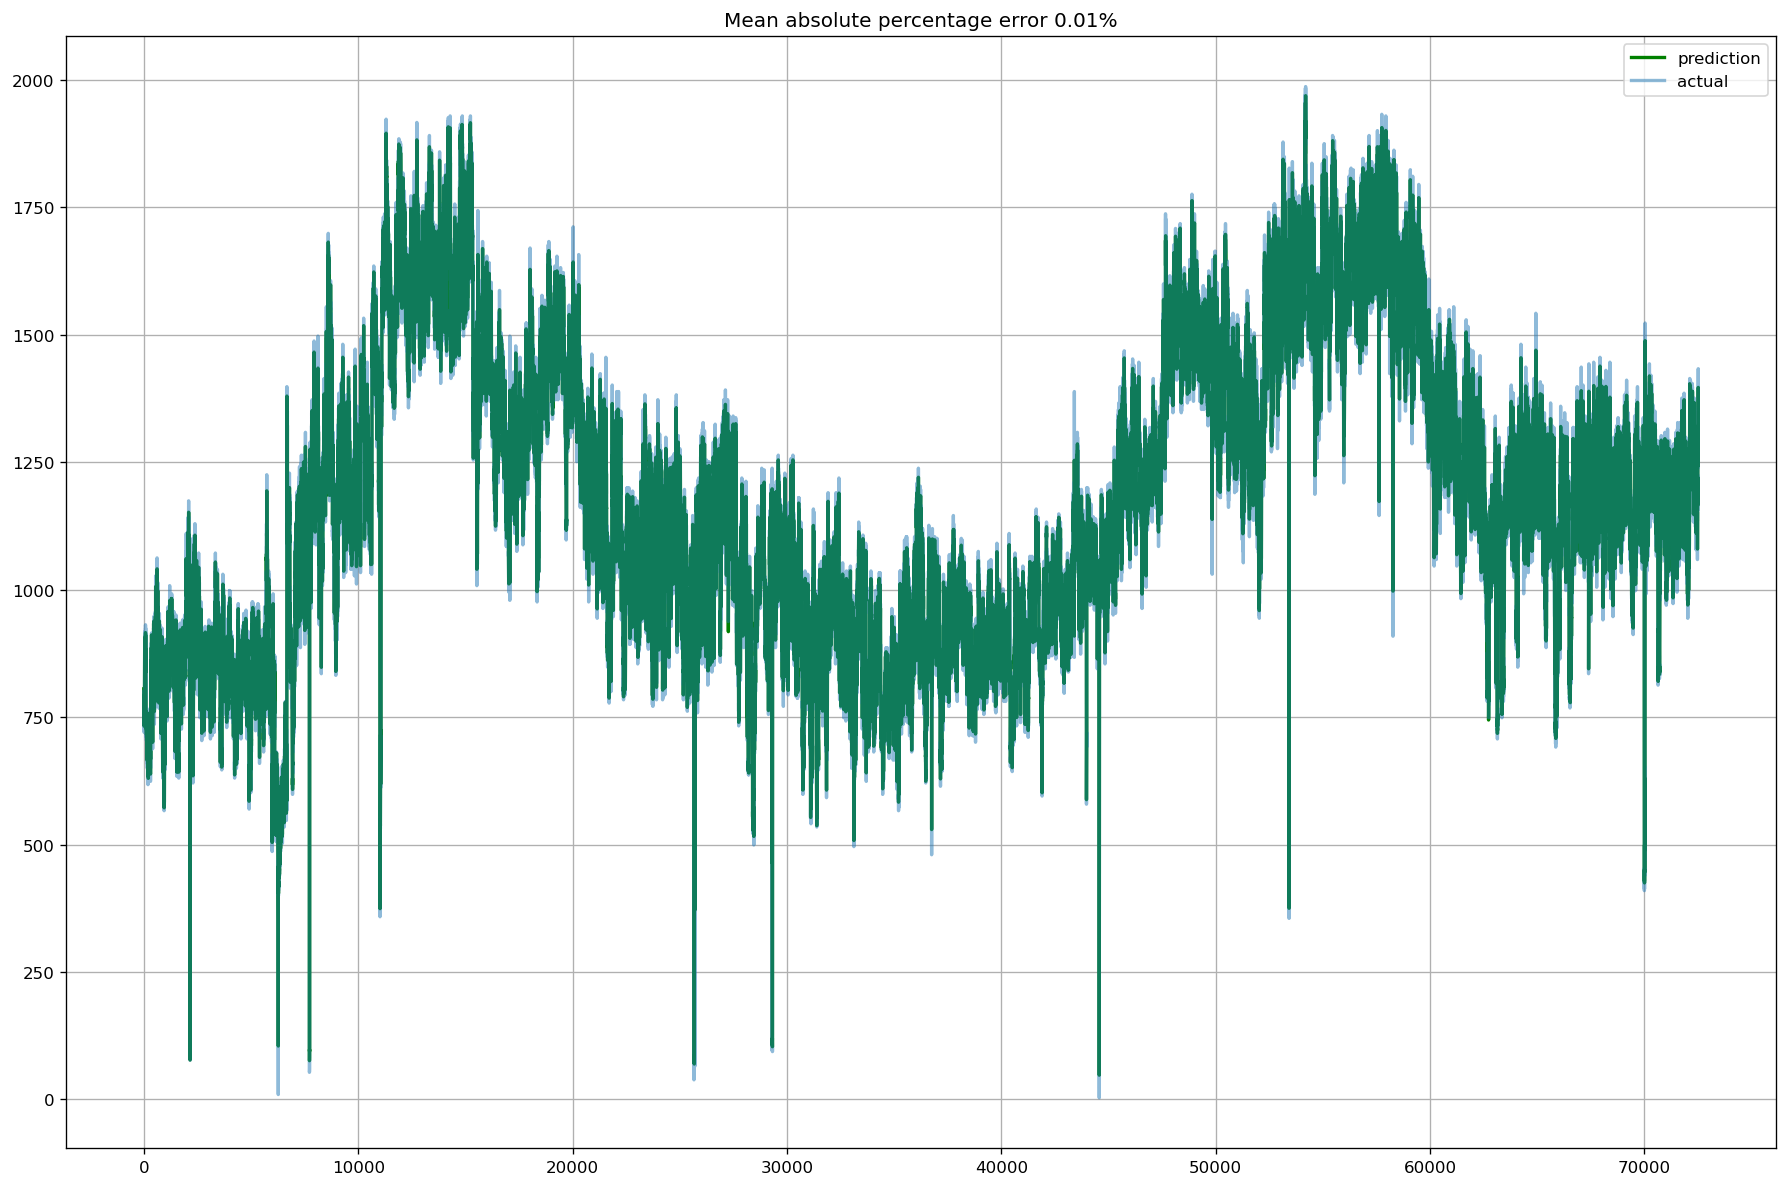

In [95]:
def plotModelTrainingResults(model, X_train=X_train, X_test=X_test):
  
    prediction = model.predict(X_train)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_train.values, label="actual", linewidth=2.0, alpha=0.5)

    mape_error_var = mean_absolute_percentage_error(y_train, prediction)
    mae_error_var = mean_absolute_error(y_train, prediction)
    mse_error_var = mean_squared_error(y_train, prediction, squared=True)
    rmse_error_var = mean_squared_error(y_train, prediction, squared=False)
    
    plt.title("Mean absolute percentage error {0:.2f}%".format(mape_error_var))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
    results = pd.DataFrame({'Actual':y_train, 
                            'Prediction':prediction  
                           })
    
    return results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var
    
train_results, train_mape_error_var, train_mae_error_var, train_mse_error_var, train_rmse_error_var = plotModelTrainingResults(random_forest_model)

In [96]:
train_results.tail(10)

,Actual,Prediction
73484,1318.4,1314.5408
73485,1318.4,1312.8064
73486,1331.2,1320.0864
73487,1270.4,1288.8416
73488,1340.8,1316.4032
73489,1356.8,1350.0480
73490,1340.8,1339.9296
73491,1379.2,1361.6256
73492,1433.6,1396.9024
73493,1257.6,1305.3888


In [97]:
train_results.to_csv('15m_RandomForest_Model_Train_Results.csv')

In [98]:
print('MAPE: ' , train_mape_error_var)
print('MAE: ', train_mae_error_var)
print('MSE: ', train_mse_error_var)
print('RMSE: ', train_rmse_error_var)

MAPE:  0.00991370280930415
MAE:  10.121080397964684
MSE:  207.45534465772846
RMSE:  14.403310197927713


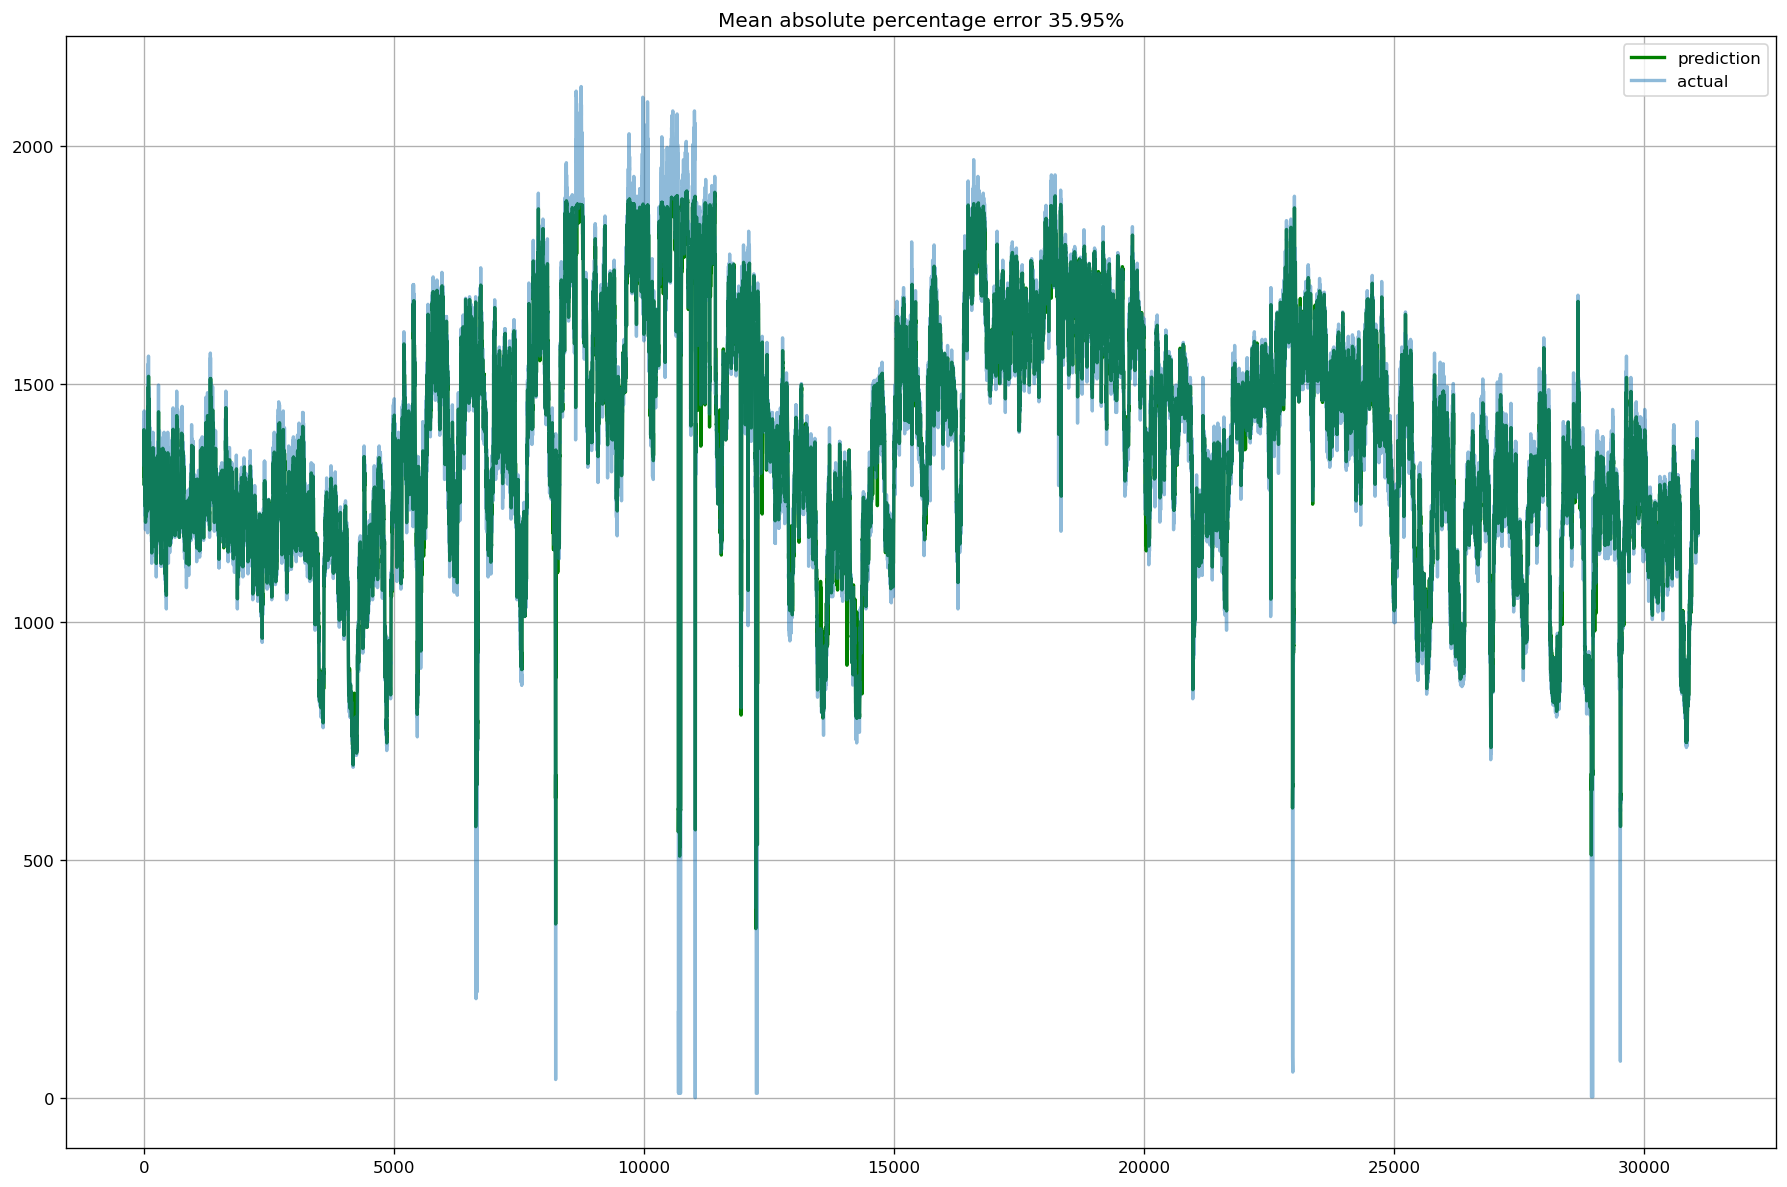

In [99]:
def plotModelPredictions(model, X_train=X_train, X_test=X_test):
  
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0, alpha=0.5)

    mape_error_var = mean_absolute_percentage_error(y_test,prediction)
    mae_error_var = mean_absolute_error(y_test,prediction)
    mse_error_var = mean_squared_error(y_test,prediction, squared=True)
    rmse_error_var = mean_squared_error(y_test,prediction, squared=False)
    
    plt.title("Mean absolute percentage error {0:.2f}%".format(mae_error_var))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
    results = pd.DataFrame({'Actual':y_test, 
                            'Prediction':prediction  
                           })
    
    return results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var
    
results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var = plotModelPredictions(random_forest_model)

In [100]:
results.tail(10)

,Actual,Prediction
104598,1206.4,1227.4144
104599,1200.0,1215.7536
104600,1203.2,1212.6688
104601,1238.4,1211.2704
104602,1190.4,1232.2624
104603,1190.4,1192.0128
104604,1180.8,1210.3488
104605,1219.2,1186.1504
104606,1238.4,1225.4304
104607,1187.2,1231.2960


In [101]:
results.to_csv('15m_RandomForest_Model_Test_Results.csv')

In [102]:
print('MAPE: ' , mape_error_var)
print('MAE: ', mae_error_var)
print('MSE: ', mse_error_var)
print('RMSE: ', rmse_error_var)

MAPE:  2.013655437597173
MAE:  35.946335335263804
MSE:  3901.663502847656
RMSE:  62.463297246044064


<AxesSubplot:xlabel='Features'>

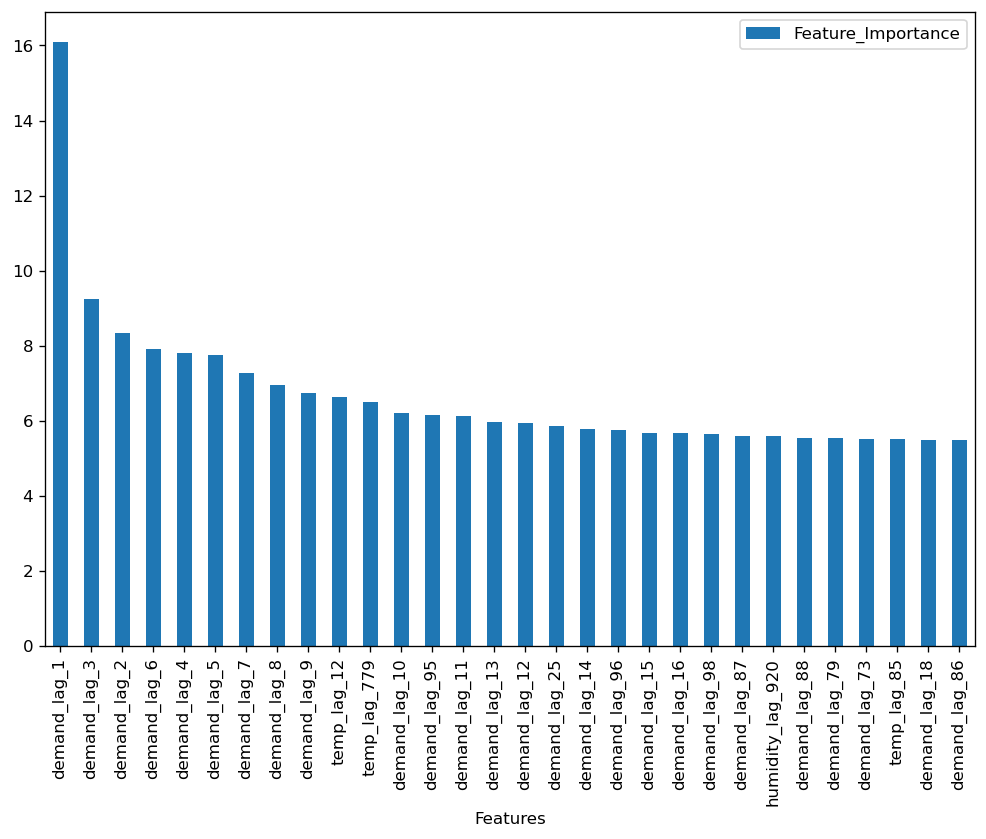

In [88]:
features = X.columns.to_numpy().reshape((2880,1))
feature_importances = random_forest_model.feature_importances_.reshape((2880,1))

feature_importance_pd = pd.concat([pd.DataFrame(features, columns = ['Features']), pd.DataFrame(np.log(feature_importances*10000000), columns = ['Feature_Importance'])], axis=1)
feature_importance_pd = feature_importance_pd.sort_values(by=['Feature_Importance'], ascending=False)
feature_importance_pd.head(30).plot.bar(x='Features' , y='Feature_Importance')

In [79]:
feature_importance_pd

,Features,Feature_Importance
3,demand_lag_1,9.806318e-01
9,demand_lag_3,1.040260e-03
6,demand_lag_2,4.195786e-04
18,demand_lag_6,2.753710e-04
12,demand_lag_4,2.445804e-04
...,...,...
1798,temp_lag_599,2.012325e-06
1822,temp_lag_607,2.010069e-06
739,temp_lag_246,2.007597e-06
472,temp_lag_157,1.984001e-06
